In [1]:
import pandas as pd
import matplotlib
matplotlib.rc('font',size=8)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

%matplotlib inline

In [2]:
# I use the Johns Hopkins Covid dataset for most of my data
# https://github.com/CSSEGISandData/COVID-19/
# Here I'm hiding my import and cleaning of the data since it also reveals my local directories
# covid_support is an ignored file on this repo
# covid_support compiles the daily files from JH data and edits/cleans
from covid_support import combine, cols, states, state_info
today = pd.datetime.today().strftime('%Y-%m-%d')
latest_data = combine.index.max().strftime('%Y-%m-%d')
print("Dashboard updated:\t{} \nLatest Data:\t\t{}".format(today,latest_data))

Dashboard updated:	2021-02-06 
Latest Data:		2021-02-05


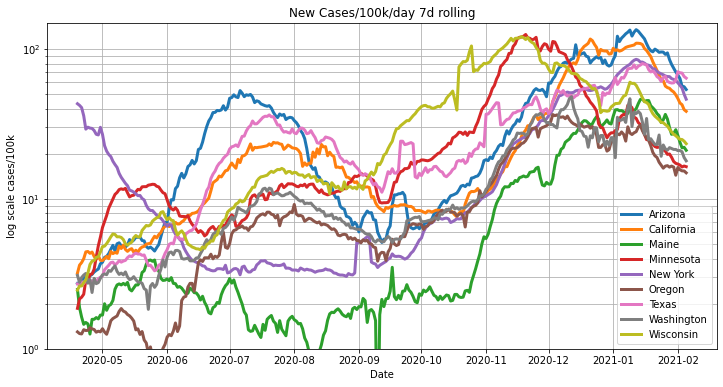

In [3]:
# Select AZ, CA, ME, NY OR,TX WA, WI
state_info = state_info.iloc[[0,1,7,8,9,12,14,15,16]]
# New Cases Per Capita
plt.figure(figsize=(12,6))
for i,r in state_info.iterrows():
    new_cases_per_pop = combine['Confirmed',r['State']].diff().rolling(7).mean()/(r['Pop']/1e5)
    plt.plot(combine.index, new_cases_per_pop,linewidth=3, label=r['State'])
plt.title('New Cases/100k/day 7d rolling')
plt.yscale('log')
plt.ylabel('log scale cases/100k')
plt.xlabel('Date')
plt.ylim(1e0,15e1)
plt.legend()
plt.grid(which='both')

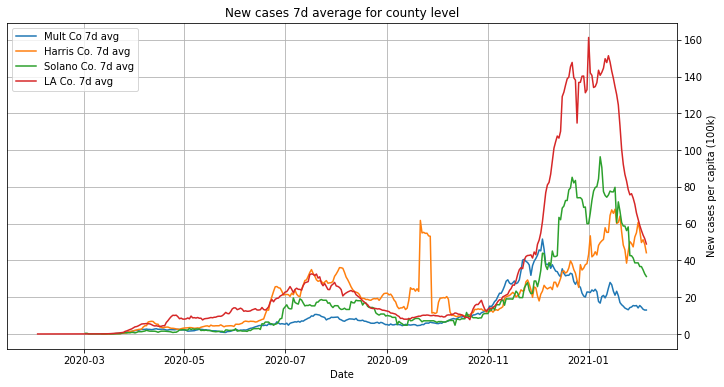

In [4]:
county_data = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
df = pd.read_csv(county_data, parse_dates=[0])

mult_pop = 812855   # 2019 pop
har_pop = 4.713e6
sol_pop = 447643
la_pop = 10.04e6

mult = df[df['county']=="Multnomah"]
mult.index = mult.date
mult['new_cases'] = mult['cases'].diff()
mult['smooth'] = mult['new_cases'].rolling(7).mean()
har = df[(df['county']=="Harris") & (df['state']=="Texas")]
har.index = har.date
har['new_cases'] = har['cases'].diff()
har['smooth'] = har['new_cases'].rolling(7).mean()
sol = df[df['county']=="Solano"]
sol.index = sol.date
sol['new_cases'] = sol['cases'].diff()
sol['smooth'] = sol['new_cases'].rolling(7).mean()
la = df[df['county']=="Los Angeles"]
la.index = la.date
la['new_cases'] = la['cases'].diff()
la['smooth'] = la['new_cases'].rolling(7).mean()

# Cases per capita on one plot
plt.figure(figsize=(12,6))
plt.plot(mult.index, mult.smooth*1e5/mult_pop, label='Mult Co 7d avg')
plt.plot(har.index, har.smooth*1e5/har_pop, label='Harris Co. 7d avg')
plt.plot(sol.index, sol.smooth*1e5/sol_pop, label='Solano Co. 7d avg')
plt.plot(la.index, la.smooth*1e5/la_pop, label='LA Co. 7d avg')
#plt.plot(ri.index, ri.smooth*1e5/ri_pop, label='Prov Co. 7d avg')
plt.xlabel('Date')
plt.ylabel('New cases per capita (100k)')
plt.title('New cases 7d average for county level')
plt.grid(which='both')
plt.legend()
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

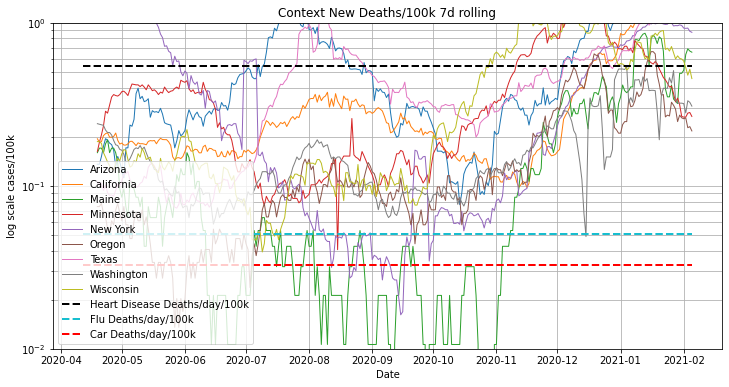

In [5]:
heart_disease = 647457/328.2e6*100000/365   # 197 per 100k people die of heart disease per year
car_deaths = 12/365 # .03 fatality per 100k per year from nhtsa in 2016
flu_deaths = 61000/328.2e6*100000/365  # Estimate for 2018 flu season from CDC, highest deaths in recent records

plt.figure(figsize=(12,6))
for i,r in state_info.iterrows():
    new_deaths_per_pop = combine['Deaths',r['State']].diff().rolling(7).mean()/(r['Pop']/1e5)
    plt.plot(combine.index, new_deaths_per_pop,linewidth=1, label=r['State'])
plt.plot((new_deaths_per_pop.index[0],new_deaths_per_pop.index[-1]),(heart_disease,heart_disease),'--',linewidth=2,c='k',label='Heart Disease Deaths/day/100k')
plt.plot((new_deaths_per_pop.index[0],new_deaths_per_pop.index[-1]),(flu_deaths,flu_deaths),'--',linewidth=2,label='Flu Deaths/day/100k')
plt.plot((new_deaths_per_pop.index[0],new_deaths_per_pop.index[-1]),(car_deaths,car_deaths),'--',linewidth=2,c='r',label='Car Deaths/day/100k')
plt.title('Context New Deaths/100k 7d rolling')
plt.yscale('log')
plt.ylabel('log scale cases/100k')
plt.xlabel('Date')
plt.ylim(1e-2,1e0)
plt.legend(loc=3)
plt.grid(which='both')

In [6]:
from IPython.display import display
tot_stats = pd.DataFrame(columns=['TotPerc','CurrentPercent'])

for i,r in state_info.iterrows():
    tot = combine['Confirmed',r['State']][-1]/(r['Pop'])
    current = combine['Confirmed',r['State']].diff().rolling(18).sum()[-1]/(r['Pop'])
    tot = "{0:.2f}%".format(tot * 100)
    current = "{0:.2f}%".format(current * 100)
    #cur_more = current * 7.7   # one paper estiamted 7.7 times undercounted cases (but we're going to only report positive tests here)
    tot_stats.loc[r['State']] = [tot,current]
    
print("Total and current percent of pop that has tested positive for covid:")
display(tot_stats)

Total and current percent of pop that has tested positive for covid:


,TotPerc,CurrentPercent
Arizona,10.66%,1.32%
California,8.60%,0.90%
Maine,3.04%,0.52%
Minnesota,8.27%,0.33%
New York,7.50%,1.04%
Oregon,3.46%,0.29%
Texas,8.55%,1.17%
Washington,4.19%,0.39%
Wisconsin,10.29%,0.51%


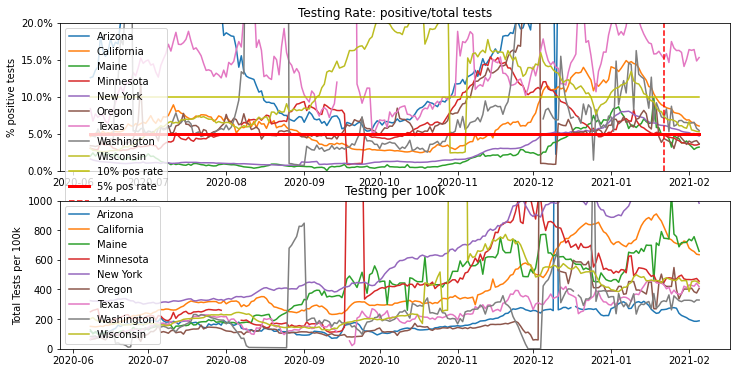

In [7]:
# Testing Rates
combine = combine['6/1/2020':]

for sub in [state_info]:
    td = combine.index[-1]
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    for i,r in sub.iterrows():
        new_cases_per_pop =  combine['Confirmed',r['State']].diff().rolling(7).mean()/(r['Pop']/1e5)
        new_tests_per_pop = combine['Testing_Rate',r['State']].diff().rolling(7).mean()
        new_tests_per_pop[new_tests_per_pop <0] = np.nan
        perc_test_pos = new_cases_per_pop/new_tests_per_pop
        plt.plot(combine.index, perc_test_pos, label=r['State'])
    plt.plot((pd.datetime(2020,6,8),td),(0.1,0.1), label='10% pos rate', c='y')
    plt.plot((pd.datetime(2020,6,8),td),(0.05,0.05), linewidth=3, label='5% pos rate', c='r')
    plt.plot([td - pd.Timedelta('14D')]*2,[0,0.2],'--',c='r',label='14d ago')
    plt.ylim(0,0.2)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.title("Testing Rate: positive/total tests")
    plt.ylabel("% positive tests")
    plt.legend(loc='upper left')
    # Testing Rates
    #plt.figure(figsize=(16,8))
    plt.subplot(2,1,2)
    for i,r in sub.iterrows():
        new_tests_per_pop = combine['Testing_Rate',r['State']].diff().rolling(7).mean()
        new_tests_per_pop[new_tests_per_pop <0] = np.nan
        plt.plot(combine.index, new_tests_per_pop, label=r['State'])
    plt.ylim(0,1000)
    plt.title("Testing per 100k")
    plt.ylabel('Total Tests per 100k')
    plt.legend(loc='upper left')